Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

sns.set()
sns.set_style("white")

%matplotlib inline

Function definitions

In [2]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def remove_nan_transpose(varlst):
    Varlst = np.array(varlst)
    res = []
    for i in range(Varlst.shape[1]):
        lst = Varlst[:,i]
        
        #Remove nan
        lst = lst[~np.isnan(lst)]
        
        res.append(lst)
        
    return res

def start_simulation_parallel(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

# Functions for using in a for loop
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 200)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');
    
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def start_simulation_to_thresh(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)
        
        y[y > y0] = np.nan
        
        #print(np.sum(~np.isnan(y)))
        # Terminate once threshold is reached
        if np.sum(~np.isnan(y)) == 0:
            #print(np.sum(~np.isnan(y)))
            #print('Breaking at ', i, '...')
            break
            
    
    return u_lst, v_lst, y_lst, I_lst, sig_lst

Parameters

In [3]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05,
              'alpha': 1}

Run simulation and plot

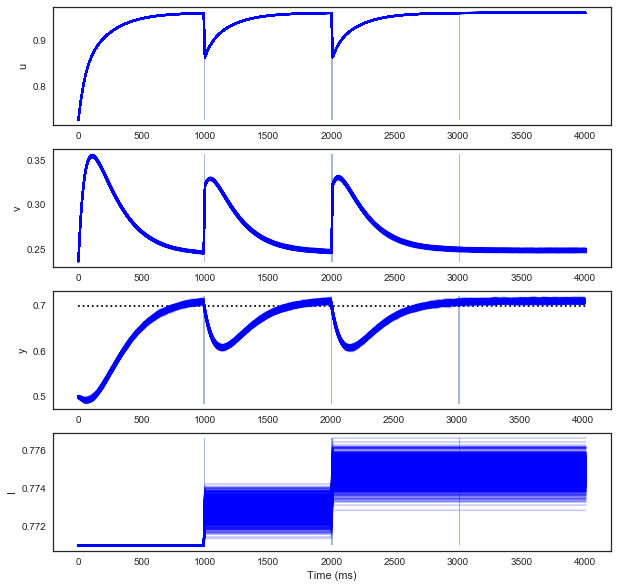

In [4]:
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=1000, sigma=0.01, K=2, initI=0.771)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Now lets run synchronization

We will start with Mates (1994) style dual process model with period and phase corrections

In [5]:
def start_dual_process_model(state_init, params, niter, duration):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    ## NOTE: reset signal is not the same as the single module network in RSG task ##
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    alpha = params['alpha']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    uS = u.copy()
    vS = v.copy()
    yS = y.copy()
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
        
    sig_lst = []
    u_sim = []
    v_sim = []
    y_sim = []
    I_lst = []
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    
    for i in range(niter): 
        
        if i % int(duration/dt) == 0 and i > 0:
            sig = 1.0
            print('flash')
        else:
            sig = 0.0
        
        # I update here:
        I += (sig * K * (yS - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        yS += (-yS + uS - vS + np.random.randn(ntrials) * sigma) / 100 * dt

        v_sim.append(vS.copy())
        u_sim.append(uS.copy())
        y_sim.append(yS.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig) 
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
            
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt

        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / 100 * dt
        
        IP = I.copy() + alpha*(yP.copy() - yS.copy())

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        
    return u_sim, v_sim, y_sim, I_lst, sig_lst, u_p, v_p, y_p, I_p

In [6]:
def simulate_synchronization(ntrials=1, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7, alpha=0.5):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    PARAMS_DICT['alpha'] = alpha
    
    nbin = int(duration / PARAMS_DICT['dt'])*nstages

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p = start_dual_process_model(state_init, PARAMS_DICT, nbin, duration)


    return usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p 

flash
flash
flash
flash
flash
flash
flash
flash
flash


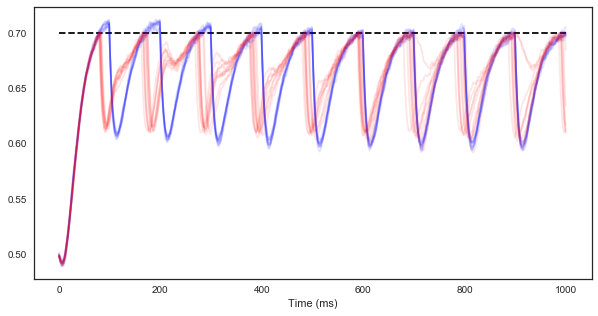

In [7]:
usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p = simulate_synchronization(ntrials=10, duration=1000, nstages=10, sigma=0.01, K=3, initI=0.771, alpha = 0.5
                                                                            )

plt.figure(figsize=(10, 5))
#a = remove_nan_transpose(siglst)
#for i in range(len(a)):
#    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.plot(ysim, 'b', alpha=0.1)
plt.plot(y_p, 'r', alpha=0.1)
plt.xlabel('Time (ms)')
#plt.ylabel('y')
plt.hlines(0.7, 0, 1000*10/PARAMS_DICT['dt'], linestyles='--')

Now lets try doing some phase shifts

In [8]:
def gauss_derivative(x,sig,amp):
    y = -amp / np.sqrt(2*np.pi*np.power(sig,2)) * x / np.power(sig,2) * np.exp( -np.power(x,2) / (2*np.power(sig,2)) )
    
    return y
    
def dual_process_model_generalized(state_init, params, niter, durations):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    alpha = params['alpha']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    uS = u.copy()
    vS = v.copy()
    yS = y.copy()
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
        
    sig_lst = []
    u_sim = []
    v_sim = []
    y_sim = []
    I_lst = []
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    production_lst = []
    
    durs = np.cumsum(np.divide(durations,dt))
    durs.astype(int)
    
    for i in range(niter): 
        
        if any(i == durs):
            sig = 1.0
            #print('flash')
        else:
            sig = 0.0
        
        # I update here:
        I += (sig * K * (yS - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            uS += (-uS + thresh_exp(Wut * I - Wuv * vS - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        yS += (-yS + uS - vS + np.random.randn(ntrials) * sigma) / 100 * dt

        v_sim.append(vS.copy())
        u_sim.append(uS.copy())
        y_sim.append(yS.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig) 
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt

        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / 100 * dt
        
        IP = I.copy() + alpha*(yP.copy() - yS.copy())
        #print((yP.copy() - yS.copy()))
        #IP = I.copy() - gauss_derivative((yP.copy() - yS.copy()),0.4,alpha)

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        production_lst.append(sigP)
        
    return u_sim, v_sim, y_sim, I_lst, sig_lst, u_p, v_p, y_p, I_p, production_lst

In [9]:
def simulate_synchronization2(ntrials=1, durations=[600, 600, 600, 600, 1000, 600, 600], sigma=0, K=3.0, initI=0.7, alpha=0.5):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    PARAMS_DICT['alpha'] = alpha
    
    nbin = int(sum(np.divide(durations,PARAMS_DICT['dt'])))
    print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.87, 
                  np.ones(ntrials) * 0.25,
                  np.ones(ntrials) * 0.5,
                  0.0]

    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = dual_process_model_generalized(state_init, PARAMS_DICT, nbin, durations)


    return usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst 

def asynchronies(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst),dt)
    flash_times = np.multiply(np.nonzero(sig_lst),dt)
    if np.size(flash_times) >= np.size(press_times):
        asynch = np.subtract(press_times[0,:],flash_times[0,:np.size(press_times)])
    else:
        asynch = np.subtract(press_times[0,:np.size(flash_times)],flash_times[0,:])
        
#def asynchronies_multi(sig_lst)
        
#    for i in range(len(flash_times)):
#        asynch[i] = press_times[i] - flash_times[i]
        
    return asynch, press_times, flash_times

def isi_ipi(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst),dt)
    flash_times = np.multiply(np.nonzero(sig_lst),dt)
    
    isi = np.diff(flash_times)
    ipi = np.diff(press_times)
    
    return isi, ipi, press_times, flash_times

Event onset shift

1120
[[ 61  89  84  70  84  79  73  65  71  68 101  97 106]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


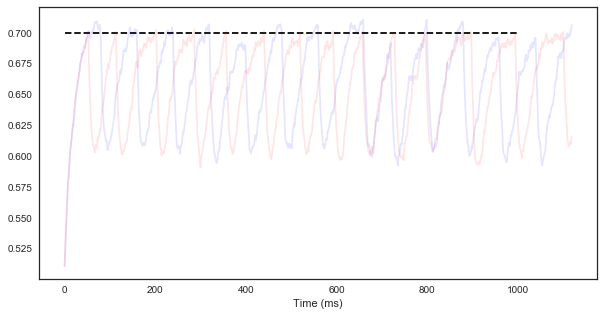

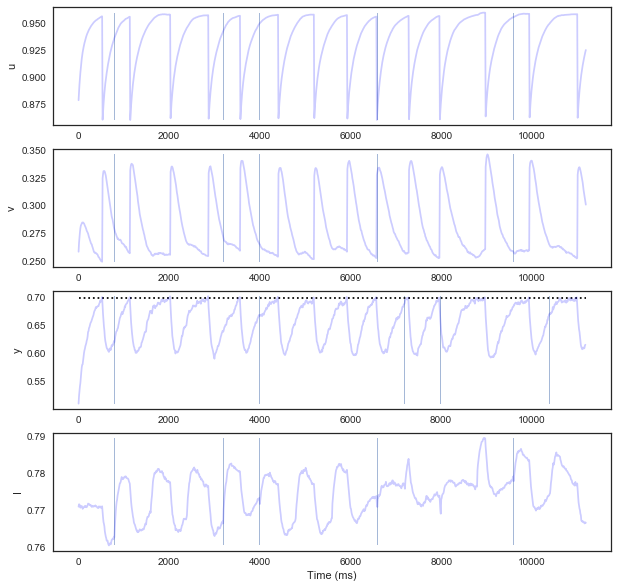

In [10]:
usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=1, 
                                                                               durations=[800, 800, 800, 800, 800, 800, 800, 1000, 600, 800, 800, 800, 800, 800], 
                                                                               sigma=0.02, K=3, initI=0.771, alpha = 0.1)


plt.figure(figsize=(10, 5))
#a = remove_nan_transpose(siglst)
#for i in range(len(a)):
#    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.plot(ysim, 'b', alpha=0.1)
plt.plot(y_p, 'r', alpha=0.1)
plt.xlabel('Time (ms)')
#plt.ylabel('y')
plt.hlines(0.7, 0, 1000*10/PARAMS_DICT['dt'], linestyles='--')
print(np.diff(np.nonzero(production_lst)))


plot_simulation_parallel(u_p, v_p, y_p, I_p, siglst, PARAMS_DICT)


[ 800  800  800  800  800  800 1000  600  800  800  800  800]
[[ 610  890  840  700  840  790  730  650  710  680 1010  970 1060]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]]


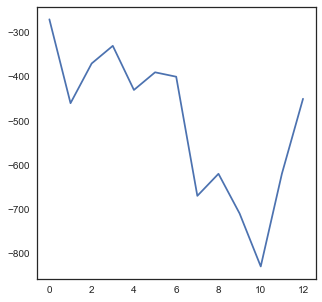

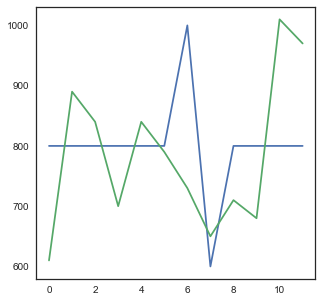

In [11]:

asynch, press_times, flash_times = asynchronies(siglst,production_lst,PARAMS_DICT['dt'])
isi, ipi, press_times, flash_times = isi_ipi(siglst,production_lst,PARAMS_DICT['dt'])
plt.figure(figsize=(5,5))
plt.plot(asynch)

plt.figure(figsize=(5,5))
plt.plot(isi[0,:])
plt.plot(ipi[0,:-1])
print(isi[0,:])
print(ipi)

Phase shift

1140
[[79 83 84 84 83 82 82 95 87 83 82 81]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]


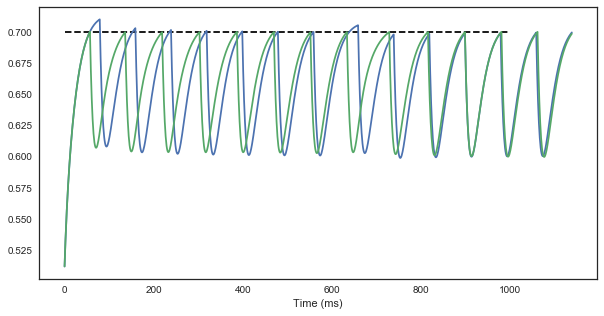

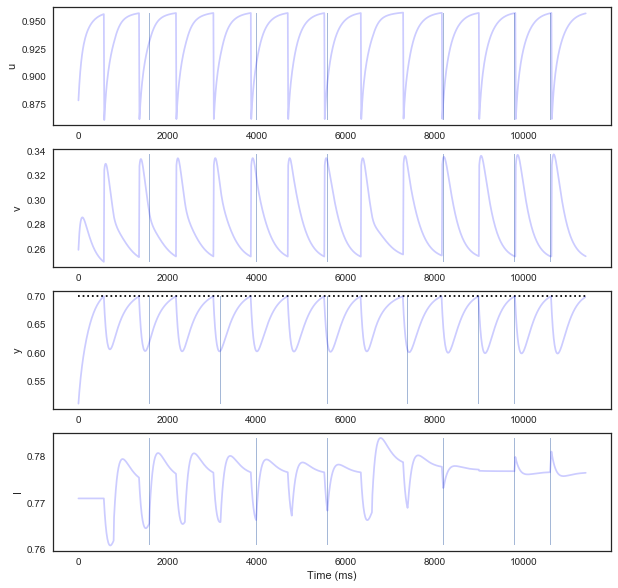

In [12]:
usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=1, 
                                                                               durations=[800, 800, 800, 800, 800, 800, 800, 1000, 800, 800, 800, 800, 800, 800], 
                                                                               sigma=0.0, K=3, initI=0.771, alpha = 0.1)

plt.figure(figsize=(10, 5))
#a = remove_nan_transpose(siglst)
#for i in range(len(a)):
#    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.plot(ysim)
plt.plot(y_p)
plt.xlabel('Time (ms)')
#plt.ylabel('y')
plt.hlines(0.7, 0, 1000*10/PARAMS_DICT['dt'], linestyles='--')
print(np.diff(np.nonzero(production_lst)))
plot_simulation_parallel(u_p, v_p, y_p, I_p, siglst, PARAMS_DICT)

[ 800  800  800  800  800  800 1000  800  800  800  800  800]
[[790 830 840 840 830 820 820 950 870 830 820 810]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


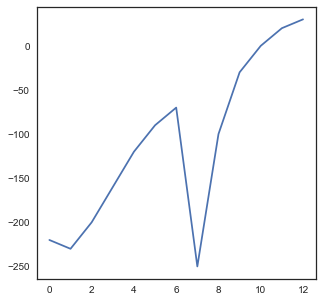

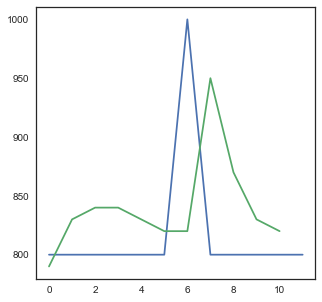

In [13]:
asynch, press_times, flash_times = asynchronies(siglst,production_lst,PARAMS_DICT['dt'])
isi, ipi, press_times, flash_times = isi_ipi(siglst,production_lst,PARAMS_DICT['dt'])
plt.figure(figsize=(5,5))
plt.plot(asynch)

plt.figure(figsize=(5,5))
plt.plot(isi[0,:])
plt.plot(ipi[0,:-1])
print(isi[0,:])
print(ipi)

Step change

1260
[[ 79  83  84  84  83  82  82  95 104 106 105 104 103]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


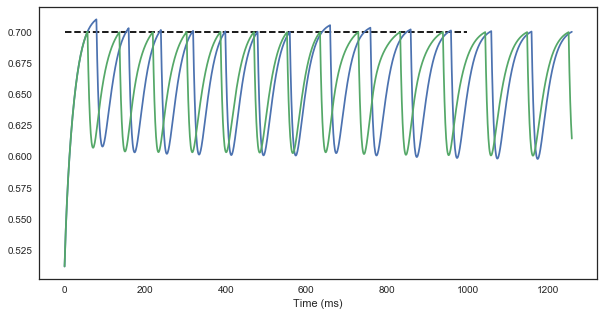

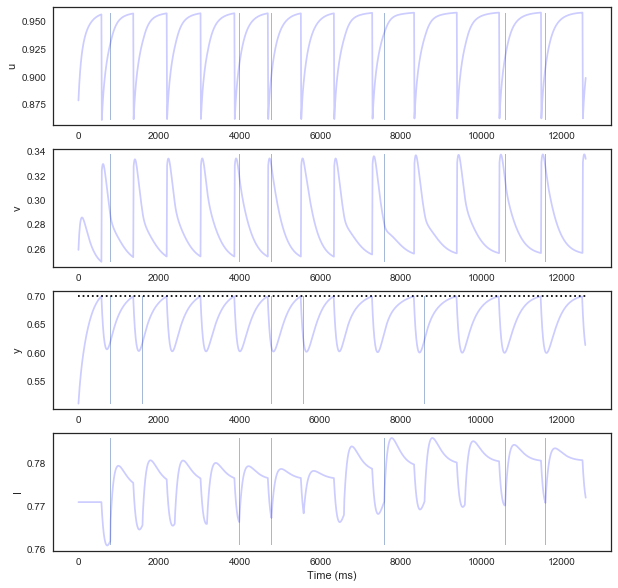

In [14]:
usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=1, 
                                                                               durations=[800, 800, 800, 800, 800, 800, 800, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 
                                                                               sigma=0.0, K=3, initI=0.771, alpha = 0.1)

plt.figure(figsize=(10, 5))
#a = remove_nan_transpose(siglst)
#for i in range(len(a)):
#    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.plot(ysim)
plt.plot(y_p)
plt.xlabel('Time (ms)')
#plt.ylabel('y')
plt.hlines(0.7, 0, 1000*10/PARAMS_DICT['dt'], linestyles='--')
print(np.diff(np.nonzero(production_lst)))
plot_simulation_parallel(u_p, v_p, y_p, I_p, siglst, PARAMS_DICT)

[ 800  800  800  800  800  800 1000 1000 1000 1000 1000 1000]
[[ 790  830  840  840  830  820  820  950 1040 1060 1050 1040 1030]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]]


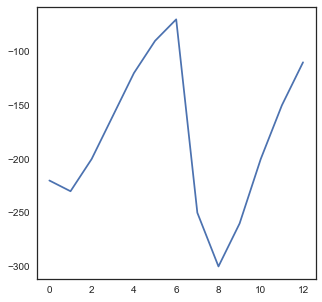

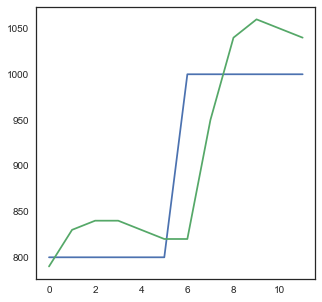

In [15]:
asynch, press_times, flash_times = asynchronies(siglst,production_lst,PARAMS_DICT['dt'])
isi, ipi, press_times, flash_times = isi_ipi(siglst,production_lst,PARAMS_DICT['dt'])
plt.figure(figsize=(5,5))
plt.plot(asynch)

plt.figure(figsize=(5,5))
plt.plot(isi[0,:])
plt.plot(ipi[0,:-1])
print(isi[0,:])
print(ipi)

Lets look at what happens when a few beats are removed

1140
[[ 79  83  84  84  83  82  72 105  89  84  82  81]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


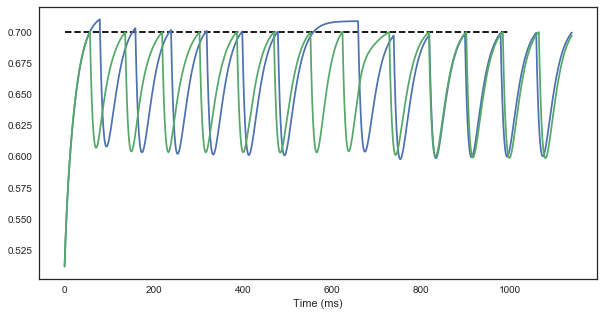

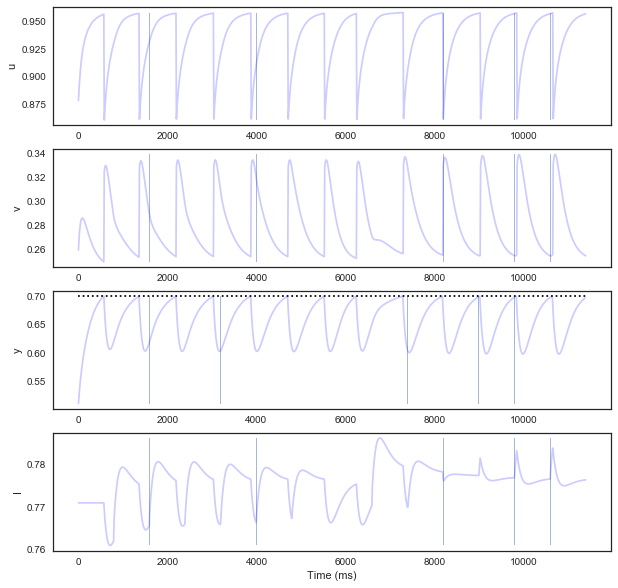

In [16]:
usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=1, 
                                                                               durations=[800, 800, 800, 800, 800, 800, 1800, 800, 800, 800, 800, 800, 800], 
                                                                               sigma=0.0, K=3, initI=0.771, alpha = 0.1)

plt.figure(figsize=(10, 5))
#a = remove_nan_transpose(siglst)
#for i in range(len(a)):
#    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.plot(ysim)
plt.plot(y_p)
plt.xlabel('Time (ms)')
#plt.ylabel('y')
plt.hlines(0.7, 0, 1000*10/PARAMS_DICT['dt'], linestyles='--')
print(np.diff(np.nonzero(production_lst)))
plot_simulation_parallel(u_p, v_p, y_p, I_p, siglst, PARAMS_DICT)

[ 800  800  800  800  800 1800  800  800  800  800  800]
[[ 790  830  840  840  830  820  720 1050  890  840  820  810]
 [   0    0    0    0    0    0    0    0    0    0    0    0]]


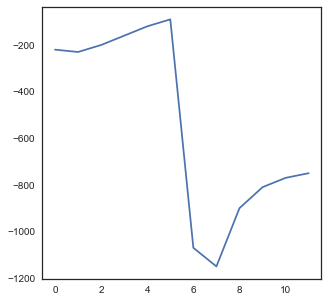

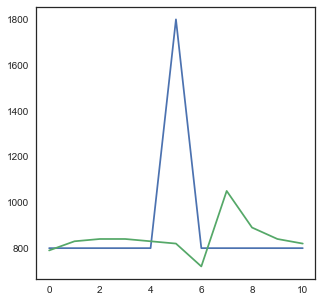

In [17]:
asynch, press_times, flash_times = asynchronies(siglst,production_lst,PARAMS_DICT['dt'])
isi, ipi, press_times, flash_times = isi_ipi(siglst,production_lst,PARAMS_DICT['dt'])
plt.figure(figsize=(5,5))
plt.plot(asynch)

plt.figure(figsize=(5,5))
plt.plot(isi[0,:])
plt.plot(ipi[0,:-1])
print(isi[0,:])
print(ipi)